In [51]:
# pip install keras

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import keras
from keras import layers
from keras.layers import Input,Add,Dense,Activation,ZeroPadding2D,BatchNormalization,Flatten,Conv2D,AveragePooling2D,MaxPooling2D
from keras.models import Model,load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.layers.advanced_activations import LeakyReLU

import tensorflow as tf
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow


In [2]:
keras.__version__

'2.4.3'

Found 4788 images belonging to 4 classes.
Found 724 images belonging to 4 classes.
배치 데이터 크기: (20, 224, 224, 3)
배치 레이블 크기: (20,)
배치 레이블: 3.0


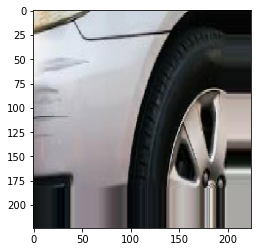

In [17]:
from IPython.display import Image, display, clear_output
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255)   # 모든 이미지를 1/255로 스케일을 조정합니다
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "how2_train"
validation_dir = 'how2_val'

train_generator = train_datagen.flow_from_directory( \
        train_dir,         # 타깃 디렉터리
        target_size=(224, 224),             # 모든 이미지를 224 × 224 크기
        batch_size=20 ,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    print('배치 레이블:', labels_batch[0])
    break
    
import matplotlib.pyplot as plt
plt.imshow( train_generator[0][0][0])
plt.show()



In [4]:
def identity_block(X,f,filters):
    F1,F2,F3 =filters
    X_shortcut=X
    
    X=Conv2D(filters=F1,kernel_size=(1,1),strides=(1,1),padding='valid')(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation(LeakyReLU(0.2))(X)
    
    X=Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same')(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation(LeakyReLU(0.2))(X)
    
    X=Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid')(X)
    X=BatchNormalization(axis=3)(X)
    
    X=Add()([X,X_shortcut])
    X=Activation(LeakyReLU(0.2))(X)
    
    return X

In [5]:
def convolutional_block(X,f,filters,s=2):
    F1,F2,F3 =filters
    X_shortcut=X
    
    X=Conv2D(filters=F1,kernel_size=(1,1),strides=(s,s))(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation(LeakyReLU(0.2))(X)
    
    X=Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same')(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation(LeakyReLU(0.2))(X)
    
    X=Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid')(X)
    X=BatchNormalization(axis=3)(X)
    
    X_shortcut=Conv2D(filters=F3,kernel_size=(1,1),strides=(s,s),padding='valid')(X_shortcut)
    X_shortcut=BatchNormalization(axis=3)(X_shortcut)
    
    X=Add()([X,X_shortcut])
    X=Activation(LeakyReLU(0.2))(X)
    
    return X

In [13]:
def ResNet50(input_shape=(224,224,3),classes=4):
    X_input=Input(input_shape)
    
    X=ZeroPadding2D((3,3))(X_input)
    #1
    X=Conv2D(64,(7,7),strides=(2,2))(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation(LeakyReLU(0.2))(X)
    X=MaxPooling2D((3,3),strides=(2,2))(X)
    
    #2
    X=convolutional_block(X,f=3,filters=[64,64,256],s=1)
    
    X=identity_block(X,3,[64,64,256])
    #3
    X=convolutional_block(X,f=3,filters=[128,128,512],s=2)
    X=identity_block(X,3,[128,128,512])
    #4
    X=convolutional_block(X,f=3,filters=[256,256,1024],s=2)
    X=identity_block(X,3,[256,256,1024])
    #5
    X=convolutional_block(X,f=3,filters=[512,512,2048],s=2)
    X=identity_block(X,3,[512,512,2048])
    #AVGPOOL
    X=AveragePooling2D((2,2),name="avg_pool")(X)
    
    #output layer
    X=Flatten()(X)
    X=Dense(classes,activation='softmax',name='fc'+str(classes),kernel_initializer = glorot_uniform(seed=0))(X)
    
    model=Model(inputs=X_input,outputs=X,name='ResNet50')
    
    return model
    
    

In [14]:
# categories = ['crash','dent','glb','scratch']
# classes = len(categories)

model =ResNet50(input_shape=(224,224,3),classes=4)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=keras.metrics.CategoricalAccuracy(name='acc'))
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 112, 112, 64) 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_87 (BatchNo (None, 112, 112, 64) 256         conv2d_87[0][0]                  
___________________________________________________________________________________________

In [ ]:
###########################################################
# 학습
###########################################################
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


checkpoint = ModelCheckpoint ( "resnet_leakyrelu_model.h5", monitor = 'val_acc', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto', period = 1)
early = EarlyStopping (monitor = 'val_acc', min_delta = 0,patience = 20, verbose = 1, mode = 'auto')


history = model.fit_generator(steps_per_epoch=(4788 /20),
                              generator=train_generator, 
                              validation_data= validation_generator, 
                              validation_steps=(724 /20),
                              epochs=15,
                              callbacks=[checkpoint,early])

# history = model.fit_generator(train_generator,
#                              steps_per_epoch=int(1840/20),
#                              epochs = 5,
#                              validation_data = validation_generator,
#                              validation_steps =int(460/20))

 



###########################################################
# 학습 결과 정확도 및 비용 그래프
###########################################################
import matplotlib.pyplot as plt 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

########################################################
import matplotlib.pyplot as plt
# print( model.predict( [[  train_generator[10][0][0] ]]) ) #
# plt.imshow(  train_generator[10][0][0] )
# plt.show()

Epoch 1/15
239/239 [==============================] - 2202s 9s/step - loss: 0.8260 - acc: 0.4396 - val_loss: 2.3389 - val_acc: 0.7541

Epoch 00001: val_acc improved from -inf to 0.75414, saving model to resnet_leakyrelu_model.h5
Epoch 2/15
239/239 [==============================] - 2234s 9s/step - loss: 0.7873 - acc: 0.4346 - val_loss: 0.7936 - val_acc: 0.4213

Epoch 00002: val_acc did not improve from 0.75414
Epoch 3/15
239/239 [==============================] - 2338s 10s/step - loss: 0.7354 - acc: 0.4248 - val_loss: 0.6324 - val_acc: 0.4945

Epoch 00003: val_acc did not improve from 0.75414
Epoch 4/15
239/239 [==============================] - 2321s 10s/step - loss: 0.6937 - acc: 0.4146 - val_loss: 1.3568 - val_acc: 0.3191

Epoch 00004: val_acc did not improve from 0.75414
Epoch 5/15
239/239 [==============================] - 2261s 9s/step - loss: 0.6764 - acc: 0.4175 - val_loss: 0.8146 - val_acc: 0.5939

Epoch 00005: val_acc did not improve from 0.75414
Epoch 6/15
239/239 [=========